<a href="https://colab.research.google.com/github/parthvishah/COVID19-India/blob/master/Covid19India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from datetime import datetime
from dateutil.parser import parse
plt.style.use('fivethirtyeight')
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
population = pd.read_csv('population_india_census2011.csv')

In [0]:
import json
from pandas.io.json import json_normalize

## **General Stats of India:**

In [4]:
df_india_test = pd.io.json.json_normalize(requests.get('https://api.rootnet.in/covid19-in/stats/testing/history').json()['data']).rename(columns = {"totalIndividualsTested":"c_individualtest","totalPositiveCases":"c_positive","totalSamplesTested":"c_tests"})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [5]:
df_india_test

,day,c_tests,c_individualtest,c_positive,source
0,2020-03-12,6500.0,5900.0,78.0,Press_Release_ICMR_13March2020.pdf
1,2020-03-18,13125.0,12235.0,150.0,ICMR_website_update_18March_6PM_IST.pdf
2,2020-03-19,14175.0,13285.0,182.0,ICMR_website_update_19March_6PM_IST.pdf
3,2020-03-20,15404.0,14514.0,236.0,ICMR_website_update_20March_6PM_IST.pdf
4,2020-03-21,16911.0,16021.0,315.0,ICMR_website_update_21March_6PM_IST.pdf
5,2020-03-22,18127.0,17237.0,396.0,ICMR_website_update_22March_6PM_IST.pdf
6,2020-03-23,20707.0,19817.0,471.0,ICMR_website_update_23March_8PM_IST.pdf
7,2020-03-24,22694.0,21804.0,536.0,ICMR_website_update_24March_8PM_IST.pdf
8,2020-03-25,25144.0,24254.0,581.0,ICMR_website_update_25March_8PM_IST.pdf
9,2020-03-26,NaN,NaN,NaN,


In [0]:
df_india_test["p2t_ratio"]= np.round(100*df_india_test["c_positive"]/df_india_test["c_tests"],2)
df_india_test["positive"] = df_india_test["c_positive"].diff()
df_india_test["tests"] = df_india_test["c_tests"].diff()
df_india_test["p2t_ratio"]= np.round(100*df_india_test["positive"]/df_india_test["tests"],2)
df_india_test = df_india_test[1:]

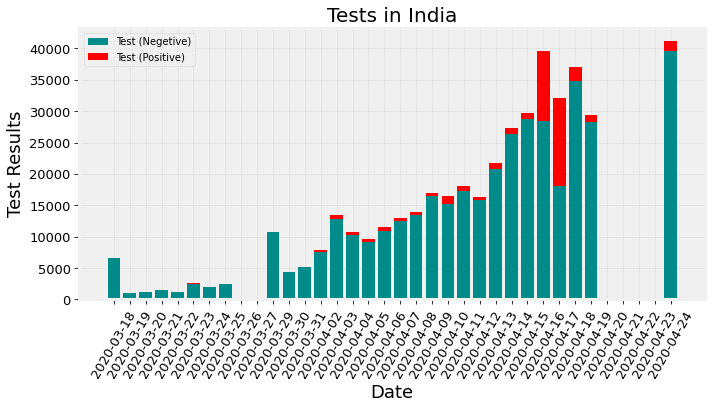

In [7]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.bar(df_india_test["day"],df_india_test["tests"].values[:],color="darkcyan",label="Test (Negetive)"+str())
plt.bar(df_india_test["day"],df_india_test["positive"].values[:],bottom=df_india_test["tests"].values[:]-df_india_test["positive"].values[:],color="Red",label="Test (Positive)")
plt.tick_params(size=5,labelsize = 13)
plt.tick_params(axis="x",size=5,labelsize = 13,labelrotation=60 )
plt.xlabel("Date",fontsize=18)
plt.ylabel("Test Results",fontsize=18)

plt.title("Tests in India",fontsize=20)
plt.grid(alpha=0.3)
plt.legend()

In [8]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [9]:
total = df_india.sum()
total.name = "Total"
pd.DataFrame(total).transpose().style.background_gradient(cmap='Wistia',axis=1)

,confirmed,recovered,deaths,active
Total,24434,5457,780,18197


In [10]:
df_india.style.background_gradient(cmap='Wistia')

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,6817,957,301,5559
Delhi,2514,857,53,1604
Gujarat,2815,265,127,2423
Rajasthan,2034,493,32,1509
Tamil Nadu,1755,866,22,867
Madhya Pradesh,1846,210,92,1544
Uttar Pradesh,1621,226,25,1370
Telangana,970,252,25,693
Andhra Pradesh,955,145,29,781


In [11]:
df_india[df_india['deaths'] > 0].style.background_gradient(cmap='Wistia')

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,6817,957,301,5559
Delhi,2514,857,53,1604
Gujarat,2815,265,127,2423
Rajasthan,2034,493,32,1509
Tamil Nadu,1755,866,22,867
Madhya Pradesh,1846,210,92,1544
Uttar Pradesh,1621,226,25,1370
Telangana,970,252,25,693
Andhra Pradesh,955,145,29,781


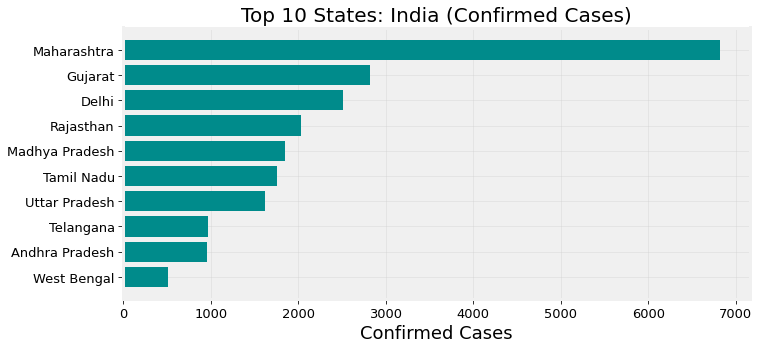

In [12]:

f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 States_India (Confirmed Cases).png')

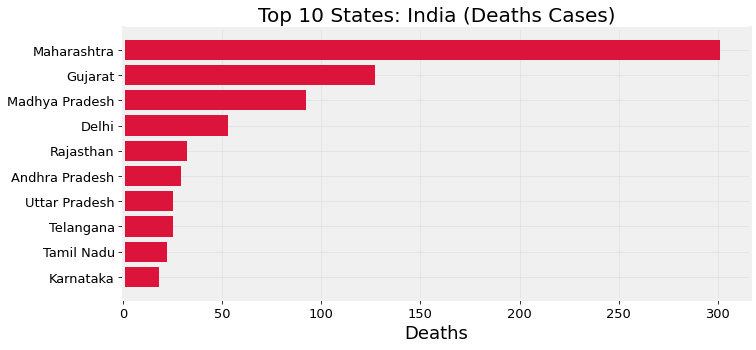

In [13]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 States_India (Deaths Cases).png')

## Merging Data (States, Hospitals, Police officers, Population, Gener Ratio):

In [14]:
police = pd.read_excel('/content/datafile.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [0]:
merged_df = population.merge(police, how = 'inner', right_on='State/UT', left_on='State / Union Territory')
merged_df.drop(['Sno','State / Union Territory','Sl.No'], axis = 1, inplace=True)

In [0]:
merged_df = merged_df.fillna(0)

In [0]:
merged_df['Total Police'] = merged_df['Sanctioned strength of Police Personnel']

In [0]:
cols = ['Total Police per lakh of population - Sanctioned','Total Police per lakh of population - Actual','Sanctioned strength of Police Personnel','onsetEstimate','Gender Ratio']

In [0]:
state_features = merged_df

In [20]:
india_data_unofficial = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org').json()
raw_patient_data = pd.io.json.json_normalize(india_data_unofficial['data']['rawPatientData'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
raw_patient_data = raw_patient_data.drop(['contractedFrom','nationality','place_attributes','relationship','travel'], axis = 1)

In [22]:
hospitals_unofficial = requests.get('https://api.rootnet.in/covid19-in/stats/hospitals').json()
hospital_data = pd.io.json.json_normalize(hospitals_unofficial['data']['regional'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
hospital_data['state'] = hospital_data['state'].str.replace('&', 'and')

In [0]:
merged_df_individual = merged_df.merge(raw_patient_data, how = 'inner', left_on='State/UT', right_on='state')

merged_df_individual = merged_df_individual.merge(hospital_data, how = 'inner', left_on = 'State/UT', right_on='state')

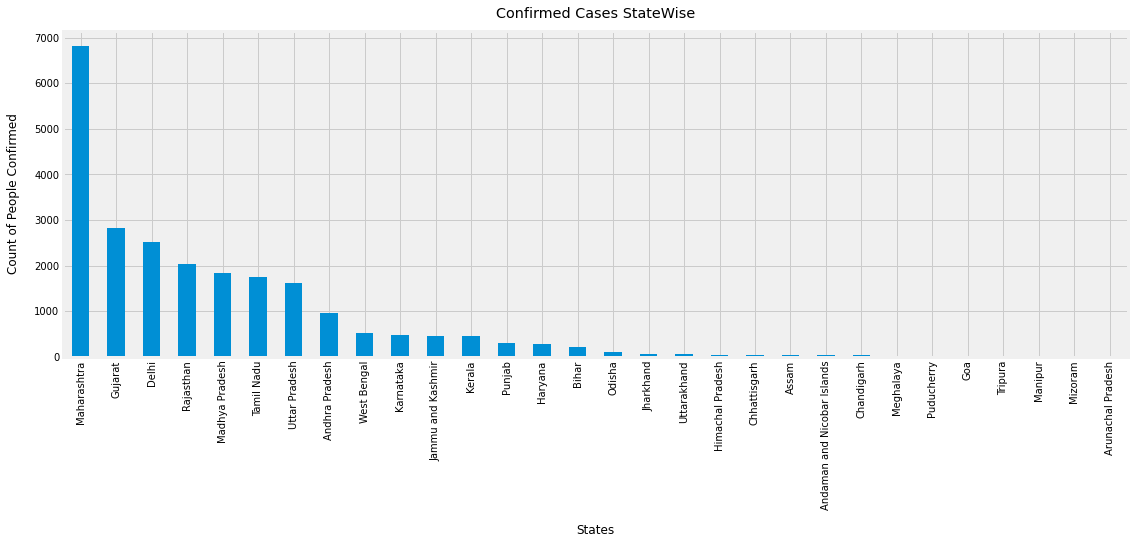

In [25]:
merged_df_individual['State/UT'].value_counts().plot(kind='bar', figsize=(17, 6))
plt.xlabel("States", labelpad=14)
plt.ylabel("Count of People Confirmed", labelpad=14)
plt.title("Confirmed Cases StateWise", y=1.02)
plt.show()

In [0]:
merged_df_individual.drop(cols, axis =1 , inplace=True)

In [0]:
#merged_df_individual.drop(['asOn','notes','state_x','state_y'], axis=1, inplace=True)
merged_df_individual.fillna(0, inplace=True)

In [28]:
merged_df_individual['ageEstimate'].unique()

array(['', '45', '16', '59', '48', '27', '22', '25', '37', '35', '20',
       '41', '19', '31', '30', '62', '73', '47', '33', '21', '39', '32',
       '53', '38', '11', '63', '18', '54', '36', '52', '50', '34', '81',
       '3', '70', '68', '65', '43', '42', '44', '51', '49', '26', '28',
       '24', '60', '64', '57', '67', '79', '40', '12', '15', '29', '10',
       '55', '2', '1', '17', '23', '14', '46', '61', '4', '8', '6', '76',
       '58', '66', '56', '77', '69', '75', '74', '71', '88', '5', '7',
       '98', '72', '78', '85', '13', '9', '80', '1.5', '0.4', '92', '90',
       '96', '89', '0.3', '28-35'], dtype=object)

[(0.0, 102.9)]

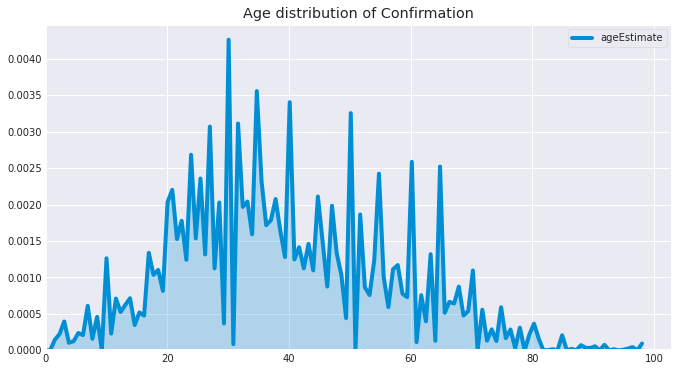

In [29]:
merged_df_individual['ageEstimate'].fillna(0)
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('28-35','30')
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('','0')
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('F','0')
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('M','0')


#merged_df_individual['ageEstimate'].astype(int)
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of Confirmation")
sns.kdeplot(data=merged_df_individual['ageEstimate'].astype(float), shade=True).set(xlim=(0))

In [0]:
merged_df_individual['reportedOn'] = pd.to_datetime(merged_df_individual['reportedOn'], dayfirst=True)

In [0]:
merged_df_individual = merged_df_individual.sort_values(by='reportedOn')

In [0]:
state_features = state_features.merge(hospital_data, how = 'inner', left_on='State/UT', right_on='state')

In [39]:
statewise_unofficial = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise/history').json()
statewise_patient_data = pd.io.json.json_normalize(statewise_unofficial['data']['history'])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
cols_date_state = statewise_patient_data['day'],statewise_patient_data['statewise']
date_state = pd.DataFrame(cols_date_state)

In [41]:
date_state = date_state.T
date_state

,day,statewise
0,2020-03-14,"[{'state': 'Andaman and Nicobar Islands', 'con..."
1,2020-03-15,"[{'state': 'Andaman and Nicobar Islands', 'con..."
2,2020-03-16,"[{'state': 'Andaman and Nicobar Islands', 'con..."
3,2020-03-17,"[{'state': 'Andaman and Nicobar Islands', 'con..."
4,2020-03-18,"[{'state': 'Andaman and Nicobar Islands', 'con..."
5,2020-03-19,"[{'state': 'Andaman and Nicobar Islands', 'con..."
6,2020-03-20,"[{'state': 'Andaman and Nicobar Islands', 'con..."
7,2020-03-21,"[{'state': 'Andaman and Nicobar Islands', 'con..."
8,2020-03-22,"[{'state': 'Andaman and Nicobar Islands', 'con..."
9,2020-03-23,"[{'state': 'Andaman and Nicobar Islands', 'con..."


In [0]:
date_state['state'] = date_state['statewise'].to_dict()

In [43]:
output = pd.DataFrame()
j = 0
for i in range(1,len(date_state['day'])):  
  output = output.append(date_state['statewise'][i], ignore_index= False)
print(output.head())

                         state  confirmed  recovered  deaths  active
0  Andaman and Nicobar Islands          0          0       0       0
1               Andhra Pradesh          1          0       0       1
2            Arunachal Pradesh          0          0       0       0
3                        Assam          0          0       0       0
4                        Bihar          0          0       0       0


In [0]:
output.reset_index(inplace=True)

In [0]:
output['diff'] = output['index'].diff()

In [46]:
output

,index,state,confirmed,recovered,deaths,active,diff
0,0,Andaman and Nicobar Islands,0,0,0,0,NaN
1,1,Andhra Pradesh,1,0,0,1,1.0
2,2,Arunachal Pradesh,0,0,0,0,1.0
3,3,Assam,0,0,0,0,1.0
4,4,Bihar,0,0,0,0,1.0
...,...,...,...,...,...,...,...
1512,32,Nagaland,0,0,0,0,1.0
1513,33,Dadra and Nagar Haveli,0,0,0,0,1.0
1514,34,Daman and Diu,0,0,0,0,1.0
1515,35,Lakshadweep,0,0,0,0,1.0


In [0]:
output['day'] = [0]*len(output)

In [48]:
j=0
for i,v in output.iterrows():
  output['day'][i] = date_state['day'][j]
  if output['diff'][i] <= 0:
    j += 1
    output['day'][i] = date_state['day'][j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [0]:
date_time_final = output
date_time_final['day'] = pd.to_datetime(date_time_final['day'], dayfirst=True)

In [50]:
date_time_final

,index,state,confirmed,recovered,deaths,active,diff,day
0,0,Andaman and Nicobar Islands,0,0,0,0,NaN,2020-03-14
1,1,Andhra Pradesh,1,0,0,1,1.0,2020-03-14
2,2,Arunachal Pradesh,0,0,0,0,1.0,2020-03-14
3,3,Assam,0,0,0,0,1.0,2020-03-14
4,4,Bihar,0,0,0,0,1.0,2020-03-14
...,...,...,...,...,...,...,...,...
1512,32,Nagaland,0,0,0,0,1.0,2020-04-23
1513,33,Dadra and Nagar Haveli,0,0,0,0,1.0,2020-04-23
1514,34,Daman and Diu,0,0,0,0,1.0,2020-04-23
1515,35,Lakshadweep,0,0,0,0,1.0,2020-04-23


In [0]:
date_time_final_try = date_time_final.merge(state_features, how = 'left', left_on='state', right_on='State/UT')

In [52]:
date_time_final_try

,index,state,confirmed,recovered,deaths,active,diff,day,Population,Rural population,Urban population,Area,Density,Gender Ratio,State/UT,Total Police per lakh of population - Sanctioned,Total Police per lakh of population - Actual,Sanctioned strength of Police Personnel,Total Police,state_x,ruralHospitals_x,ruralBeds_x,urbanHospitals_x,urbanBeds_x,totalHospitals_x,totalBeds_x,asOn_x,state_y,ruralHospitals_y,ruralBeds_y,urbanHospitals_y,urbanBeds_y,totalHospitals_y,totalBeds_y,asOn_y
0,0,Andaman and Nicobar Islands,0,0,0,0,NaN,2020-03-14,380581.0,237093.0,143488.0,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876.0,Andaman and Nicobar Islands,803.6,705.9,3747.0,3747.0,Andaman and Nicobar Islands,27.0,575.0,3.0,500.0,30.0,1075.0,2016-12-31T00:00:00.000Z,Andaman and Nicobar Islands,27.0,575.0,3.0,500.0,30.0,1075.0,2016-12-31T00:00:00.000Z
1,1,Andhra Pradesh,1,0,0,1,1.0,2020-03-14,49577103.0,34966693.0,14610410.0,"162,968 km2 (62,922 sq mi)",303/km2 (780/sq mi),993.0,Andhra Pradesh,0.0,0.0,52271.0,52271.0,Andhra Pradesh,193.0,6480.0,65.0,16658.0,258.0,23138.0,2017-01-01T00:00:00.000Z,Andhra Pradesh,193.0,6480.0,65.0,16658.0,258.0,23138.0,2017-01-01T00:00:00.000Z
2,2,Arunachal Pradesh,0,0,0,0,1.0,2020-03-14,1383727.0,1066358.0,317369.0,"83,743 km2 (32,333 sq mi)",17/km2 (44/sq mi),938.0,Arunachal Pradesh,995.5,878.4,8538.0,8538.0,Arunachal Pradesh,208.0,2136.0,10.0,268.0,218.0,2404.0,2017-12-31T00:00:00.000Z,Arunachal Pradesh,208.0,2136.0,10.0,268.0,218.0,2404.0,2017-12-31T00:00:00.000Z
3,3,Assam,0,0,0,0,1.0,2020-03-14,31205576.0,26807034.0,4398542.0,"78,438 km2 (30,285 sq mi)","397/km2 (1,030/sq mi)",954.0,Assam,200.8,169.6,34663.0,34663.0,Assam,1176.0,10944.0,50.0,6198.0,1226.0,17142.0,2017-12-31T00:00:00.000Z,Assam,1176.0,10944.0,50.0,6198.0,1226.0,17142.0,2017-12-31T00:00:00.000Z
4,4,Bihar,0,0,0,0,1.0,2020-03-14,104099452.0,92341436.0,11758016.0,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918.0,Bihar,107.7,74.8,92422.0,92422.0,Bihar,930.0,6083.0,103.0,5936.0,1033.0,12019.0,2016-12-31T00:00:00.000Z,Bihar,930.0,6083.0,103.0,5936.0,1033.0,12019.0,2016-12-31T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,32,Nagaland,0,0,0,0,1.0,2020-04-23,1978502.0,1407536.0,570966.0,"16,579 km2 (6,401 sq mi)",119/km2 (310/sq mi),931.0,Nagaland,900.8,965.8,9086.0,9086.0,Nagaland,21.0,630.0,15.0,1250.0,36.0,1880.0,2015-12-31T00:00:00.000Z,Nagaland,21.0,630.0,15.0,1250.0,36.0,1880.0,2015-12-31T00:00:00.000Z
1513,33,Dadra and Nagar Haveli,0,0,0,0,1.0,2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,34,Daman and Diu,0,0,0,0,1.0,2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515,35,Lakshadweep,0,0,0,0,1.0,2020-04-23,64473.0,14141.0,50332.0,32 km2 (12 sq mi),"2,013/km2 (5,210/sq mi)",946.0,Lakshadweep,685.4,492.7,562.0,562.0,Lakshadweep,9.0,300.0,0.0,0.0,9.0,300.0,2016-01-01T00:00:00.000Z,Lakshadweep,9.0,300.0,0.0,0.0,9.0,300.0,2016-01-01T00:00:00.000Z


In [0]:
date_time_final_try['confirm_time_diff_statewise'] = date_time_final_try.groupby(['state_x'])['confirmed'].diff().fillna(date_time_final_try['confirmed'])
date_time_final_try['death_time_diff_statewise'] = date_time_final_try.groupby(['state_x'])['deaths'].diff().fillna(date_time_final_try['deaths'])

In [54]:
date_time_final_try['confirm_time_diff_statewise'].sum()

38146.0

In [0]:
date_time_final_try = date_time_final_try.fillna(0)

In [56]:
date_time_final_try[date_time_final_try['State/UT'] == 'Maharashtra']['confirm_time_diff_statewise'].sum()

6817.0

In [0]:
cols_final_drop = ['index','state_x','active','diff','Total Police per lakh of population - Sanctioned','Total Police per lakh of population - Actual','Sanctioned strength of Police Personnel','state_y']
date_time_final_try.drop(cols_final_drop, inplace=True, axis = 1)

In [0]:
date_time_final_try['Area'] = date_time_final_try['Area'].str.split(n=1).str[0]
date_time_final_try['Area'] = date_time_final_try['Area'].str.replace(',','')
date_time_final_try['Density'] = date_time_final_try['Density'].str.split(n=1).str[0]
date_time_final_try['Density'] = date_time_final_try['Density'].str.replace(',','')



In [0]:
date_time_final_try['Density'] = date_time_final_try['Density'].str.split('/').str[0]


In [0]:
date_time_final_try.fillna(0, inplace=True)

In [61]:
date_time_final_try['Area'] = date_time_final_try['Area'].astype(int)
date_time_final_try['Density'] = date_time_final_try['Density'].astype(int)

date_time_final_try.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1516
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   state                        1517 non-null   object        
 1   confirmed                    1517 non-null   int64         
 2   recovered                    1517 non-null   int64         
 3   deaths                       1517 non-null   int64         
 4   day                          1517 non-null   datetime64[ns]
 5   Population                   1517 non-null   float64       
 6   Rural population             1517 non-null   float64       
 7   Urban population             1517 non-null   float64       
 8   Area                         1517 non-null   int64         
 9   Density                      1517 non-null   int64         
 10  Gender Ratio                 1517 non-null   float64       
 11  State/UT                     1517 non-null 

In [0]:
date = '2020-03-14'
date = datetime.strptime(date, '%Y-%m-%d')

date_time_final_try['Day'] = date_time_final_try['day'] - date

In [0]:
date_time_final_try['Day'] = date_time_final_try['Day'].astype(str).str.split( ' ').str[0]
date_time_final_try['Day'] = date_time_final_try['Day'].astype(int)

In [64]:
date_time_final_try = date_time_final_try[['Population','Rural population',	'Urban population',	'Area',	'Density','Gender Ratio'	,'State/UT',	'Total Police','ruralHospitals','ruralBeds','urbanHospitals','urbanBeds','Day','confirmed','deaths']]

KeyError: ignored

In [0]:
date_time_final_try.sort_values(by='Day', inplace=True)
date_time_final_try.reset_index(inplace=True)
date_time_final_try.fillna(0, inplace= True)

Text(0, 0.5, 'Confirmed Cases')

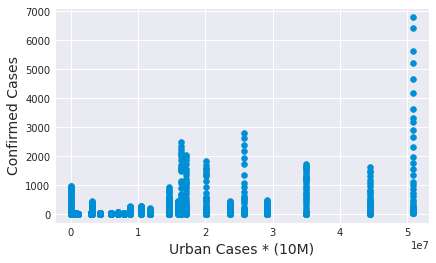

In [66]:
plt.scatter(date_time_final_try['Urban population'], date_time_final_try['confirmed'])
plt.xlabel("Urban Cases * (10M)",fontsize=14)
plt.ylabel("Confirmed Cases",fontsize=14)


Text(0, 0.5, 'Confirmed Cases')

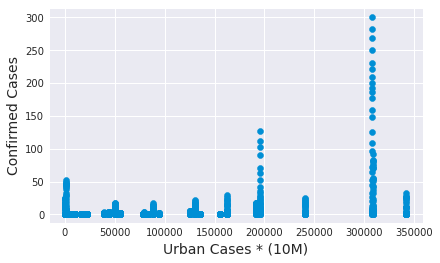

In [67]:
plt.scatter(date_time_final_try['Area'], date_time_final_try['deaths'])
plt.xlabel("Urban Cases * (10M)",fontsize=14)
plt.ylabel("Confirmed Cases",fontsize=14)


## [Predicting cases and deaths in India using all the statistics](https://)



In [0]:
X = date_time_final_try.iloc[:,:-2]
Y_death = date_time_final_try.iloc[:,-1]
Y = date_time_final_try.iloc[:,-2]
X['State/UT'] = X['State/UT'].astype(str)

In [0]:
X

,index,Population,Rural population,Urban population,Area,Density,Gender Ratio,State/UT,Total Police,ruralHospitals,ruralBeds,urbanHospitals,urbanBeds,Day
0,0,380581.0,237093.0,143488.0,8249,46,876.0,Andaman and Nicobar Islands,3747.0,27.0,575.0,3.0,500.0,0
1,21,2966889.0,2371439.0,595450.0,22429,132,989.0,Meghalaya,7840.0,143.0,1970.0,14.0,2487.0,0
2,22,2570390.0,1793875.0,776515.0,22327,122,992.0,Manipur,18527.0,23.0,730.0,7.0,697.0,0
3,23,72626809.0,52557404.0,20069405.0,308245,236,931.0,Madhya Pradesh,87366.0,334.0,10020.0,117.0,18819.0,0
4,24,1097206.0,525435.0,571771.0,21081,52,976.0,Mizoram,3858.0,56.0,604.0,34.0,1393.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,1456,25351462.0,16509359.0,8842103.0,44212,573,879.0,Haryana,59044.0,609.0,6690.0,59.0,4550.0,39
1476,1457,27743338.0,17344192.0,10399146.0,50362,550,895.0,Punjab,68902.0,510.0,5805.0,172.0,12128.0,39
1477,1458,104099452.0,92341436.0,11758016.0,94163,1102,918.0,Bihar,92422.0,930.0,6083.0,103.0,5936.0,39
1478,1450,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,39


In [0]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(X[['State/UT']]).toarray())
# merge with main df bridge_df on key values
X = X.join(enc_df)

In [0]:
X.drop(['State/UT','index'], inplace=True, axis = 1)

In [0]:
X

,Population,Rural population,Urban population,Area,Density,Gender Ratio,Total Police,ruralHospitals,ruralBeds,urbanHospitals,urbanBeds,Day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,380581.0,237093.0,143488.0,8249,46,876.0,3747.0,27.0,575.0,3.0,500.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2966889.0,2371439.0,595450.0,22429,132,989.0,7840.0,143.0,1970.0,14.0,2487.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2570390.0,1793875.0,776515.0,22327,122,992.0,18527.0,23.0,730.0,7.0,697.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72626809.0,52557404.0,20069405.0,308245,236,931.0,87366.0,334.0,10020.0,117.0,18819.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1097206.0,525435.0,571771.0,21081,52,976.0,3858.0,56.0,604.0,34.0,1393.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,25351462.0,16509359.0,8842103.0,44212,573,879.0,59044.0,609.0,6690.0,59.0,4550.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1476,27743338.0,17344192.0,10399146.0,50362,550,895.0,68902.0,510.0,5805.0,172.0,12128.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477,104099452.0,92341436.0,11758016.0,94163,1102,918.0,92422.0,930.0,6083.0,103.0,5936.0,39,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1478,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , Y
                                                    , test_size=0.1
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(X
                                                    , Y_death
                                                    , test_size=0.1
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
y_test = y_test.reset_index(drop = True)
y_test_death = y_test_death.reset_index(drop=True)
y_train.fillna(0, inplace=True)


In [0]:
#X_test = X_test.reset_index(drop = True)


In [0]:
#X_test = X_test[X_test['Population'] == 49577103.0]
#y_test = date_time_final_try['confirmed'].iloc[X_test.index]

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)


# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)


In [0]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)


# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 197.69242868030528
MSE: 123018.0775534024


In [0]:
y_test.sum(), test_linear_pred.sum()

(81769, 66924.24145861142)

In [0]:
test_linear_pred

array([ 3.97497994e+03,  1.15268862e+02,  8.72851566e+01,  9.08921325e+02,
       -9.33986006e+00,  1.82249983e+01,  7.87940940e+00,  2.52880185e+02,
        3.51426586e+01,  9.19376819e+02, -6.79152189e+00,  1.89102050e+03,
       -6.31745678e+01,  1.20029261e+03,  9.56229098e+01,  3.51426586e+01,
       -2.33543881e+01,  7.33906265e+02,  3.43260966e+01,  5.41418993e+02,
        5.84532763e+02,  3.03155887e+01,  6.12882492e+02,  2.01694009e+00,
        1.61627627e+01,  3.74813461e+01,  3.55174112e+01,  3.51426586e+01,
       -1.87187294e+02,  3.51426586e+01, -3.21019723e+01,  1.13048708e+03,
        4.42789677e+00,  2.69643534e+02,  3.77326646e+01,  3.02245121e+02,
        1.63779494e+03,  8.08539008e+02,  1.15501817e+02,  8.75975011e+01,
        9.57881973e+02, -9.27784201e+00,  1.83758411e+01,  5.84904434e+00,
        2.67178803e+02,  4.25022214e+03,  9.59811346e+02, -6.77942068e+00,
        3.51426586e+01,  2.02022638e+03, -6.27683039e+01,  1.31028888e+03,
        1.00087308e+02, -

In [0]:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)
    grid.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
test_linear_pred1 = grid.predict(X_test)
print('MAE:', mean_absolute_error(test_linear_pred1, y_test))


MAE: 106.86764705882354


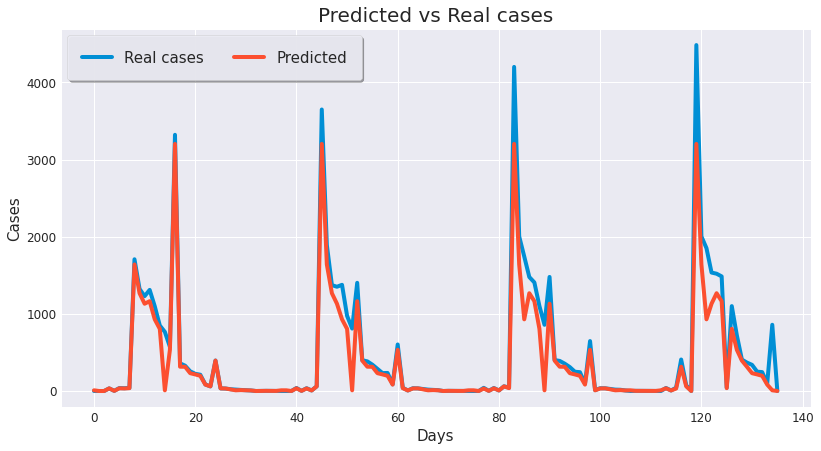

In [0]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred1, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

In [0]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 6.199181152075292
MSE: 148.42872123471224


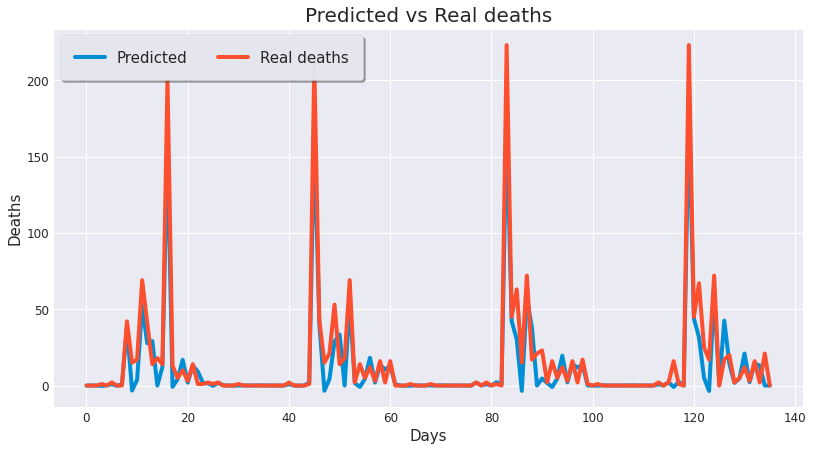

In [0]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


## Predicting Cases and Deaths in Maharashtra using only the number of cases and deaths per day

In [0]:
X = date_time_final_try.iloc[:,:-2]
Y_death = date_time_final_try.iloc[:,-1]
Y = date_time_final_try.iloc[:,-2]

In [0]:
date_time_final_try_m = date_time_final_try[date_time_final_try['State/UT'] == 'Maharashtra']

In [0]:
cases_m = date_time_final_try_m['confirmed'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
deaths_m = date_time_final_try_m['deaths'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
maharasthra_cases = np.array(cases_m).reshape(-1, 1)

maharashtra_deaths = np.array(deaths_m).reshape(-1, 1)
days_since_first_case_m = np.array([i for i in range(len(cases_m.index))]).reshape(-1, 1)
days_since_first_death_m = np.array([i for i in range(len(deaths_m.index))]).reshape(-1, 1)

days_in_future = 15
future_forcast_m = np.array([i for i in range(len(cases_m.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast_m[:-15]
future_forcast_deaths_m = np.array([i for i in range(len(deaths_m.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates_deaths = future_forcast_deaths_m[:-15]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(days_since_first_case_m
                                                    , maharasthra_cases
                                                    , test_size=0.05
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_first_death_m
                                                    , maharashtra_deaths
                                                    , test_size=0.2
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_future_forcast = poly.fit_transform(future_forcast_m)

# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)
poly_future_forcast_death = poly_death.fit_transform(future_forcast_deaths_m)

In [0]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)
linear_pred = linear_model.predict(poly_future_forcast)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 246.51919697764788
MSE: 86349.35934059185


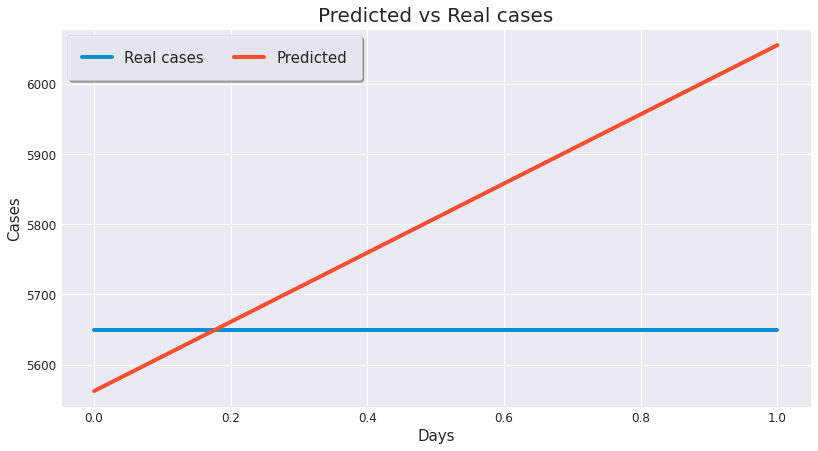

In [0]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

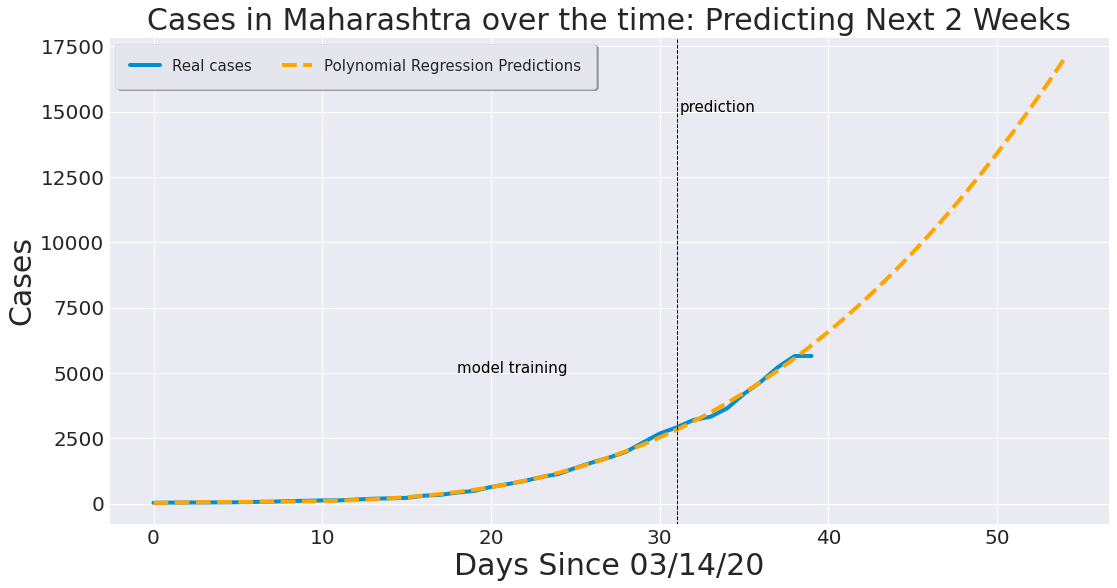

In [0]:

plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates
         , maharasthra_cases
         , label = "Real cases")

plt.plot(future_forcast_m
         , linear_pred
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='orange')

plt.title('Cases in Maharashtra over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(31, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(18, 5000
         , "model training"
         , size = 15
         , color = "black")

plt.text(31.2, 15000
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

In [0]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)
linear_pred_death = linear_model_death.predict(poly_future_forcast_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 53.37324801403743
MSE: 3213.642192210166


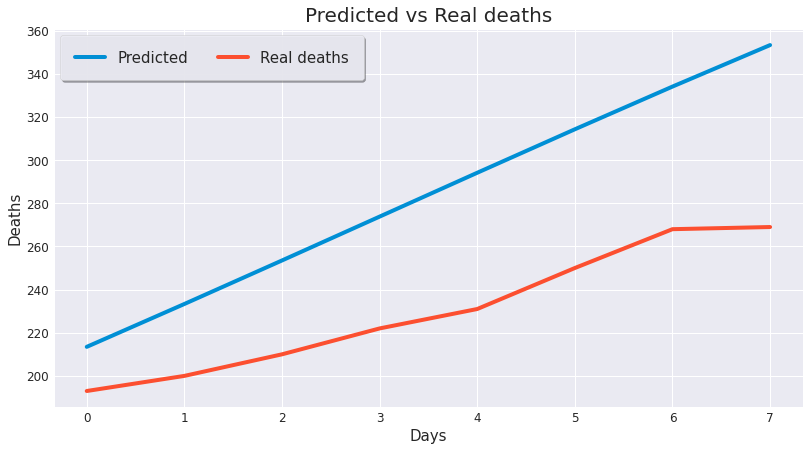

In [0]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


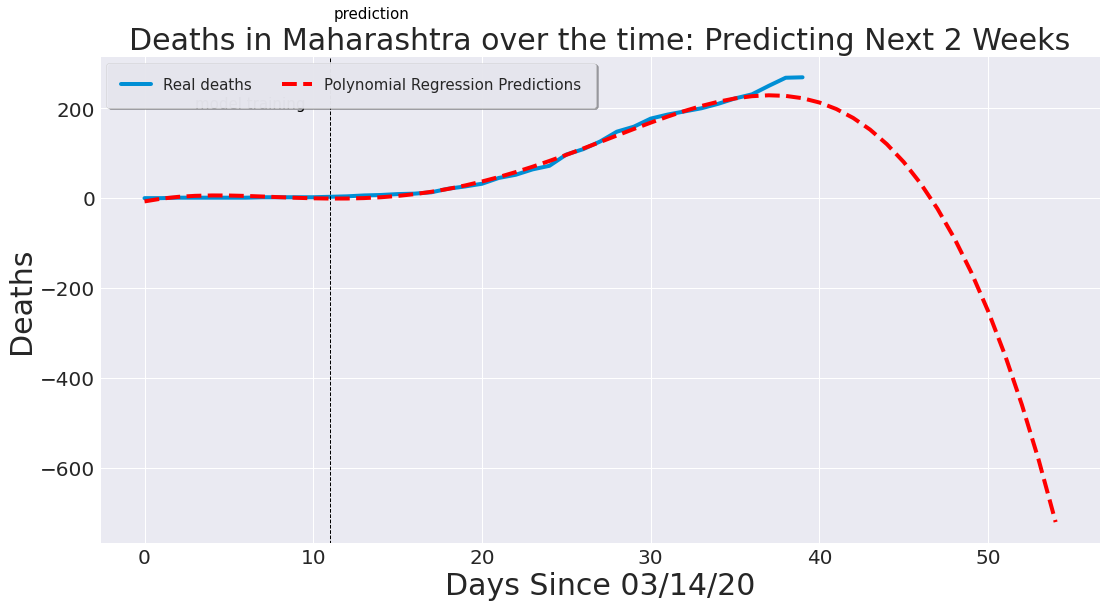

In [0]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates_deaths
         , maharashtra_deaths
         , label = "Real deaths")

plt.plot(future_forcast_deaths_m
         , linear_pred_death
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='red')

plt.title('Deaths in Maharashtra over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(11, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(3, 200
         , "model training"
         , size = 15
         , color = "black")

plt.text(11.2, 400
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

## Predicting Cases and Deaths in **India** using only the number of cases and deaths per day

In [0]:
cases = date_time_final_try['confirmed'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)

In [0]:
deaths =  date_time_final_try['deaths'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
India_cases = np.array(cases).reshape(-1, 1)

India_deaths = np.array(deaths).reshape(-1, 1)
days_since_first_case = np.array([i for i in range(len(cases.index))]).reshape(-1, 1)
days_since_first_death = np.array([i for i in range(len(deaths.index))]).reshape(-1, 1)

days_in_future = 15
future_forcast = np.array([i for i in range(len(cases.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]
future_forcast_deaths = np.array([i for i in range(len(deaths.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates_deaths = future_forcast_deaths[:-15]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(days_since_first_case
                                                    , India_cases
                                                    , test_size=0.05
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_first_death
                                                    , India_deaths
                                                    , test_size=0.2
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_future_forcast = poly.fit_transform(future_forcast)

# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)
poly_future_forcast_death = poly_death.fit_transform(future_forcast_deaths)

In [97]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)
linear_pred = linear_model.predict(poly_future_forcast)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 121.88817085602932
MSE: 21419.772211110056


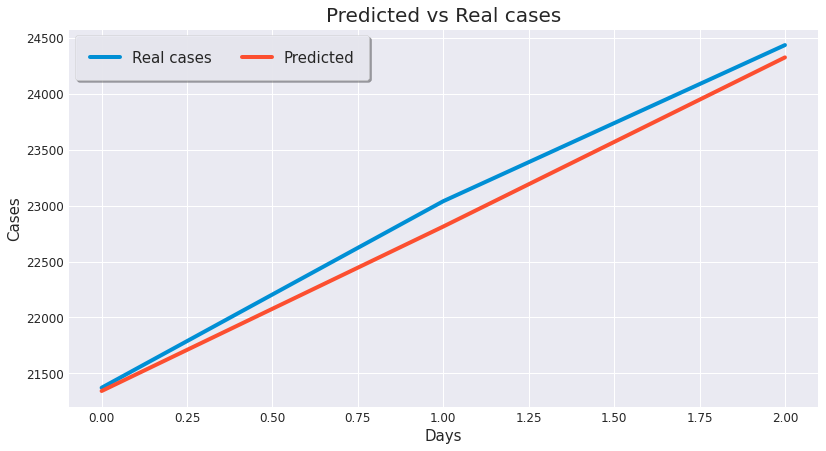

In [98]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

In [99]:
y_test.sum(), test_linear_pred.sum()

(68845, 68479.3354874319)

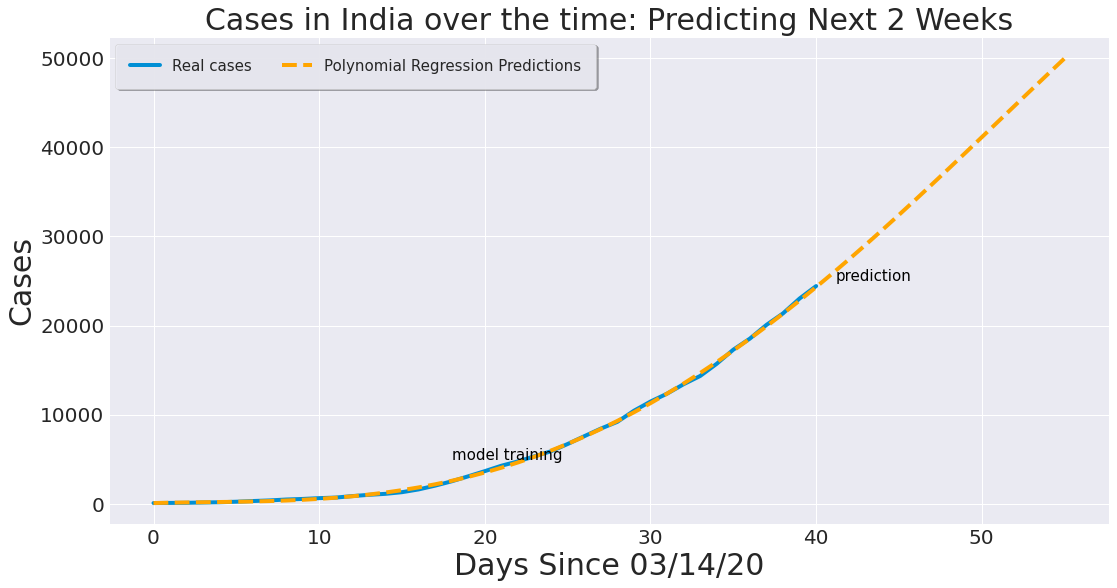

In [100]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates
         , India_cases
         , label = "Real cases")

plt.plot(future_forcast
         , linear_pred
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='orange')

plt.title('Cases in India over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)



plt.text(18, 5000
         , "model training"
         , size = 15
         , color = "black")

plt.text(41.2, 25000
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

In [101]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)
linear_pred_death = linear_model_death.predict(poly_future_forcast_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 63.64134906113668
MSE: 4554.648876885204


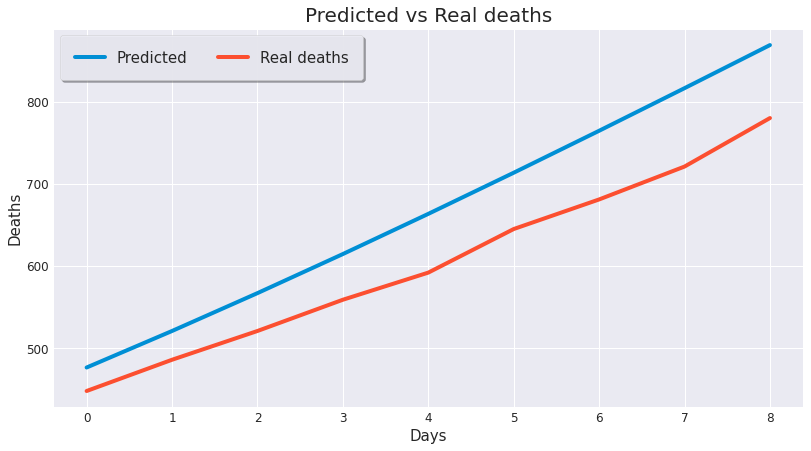

In [102]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


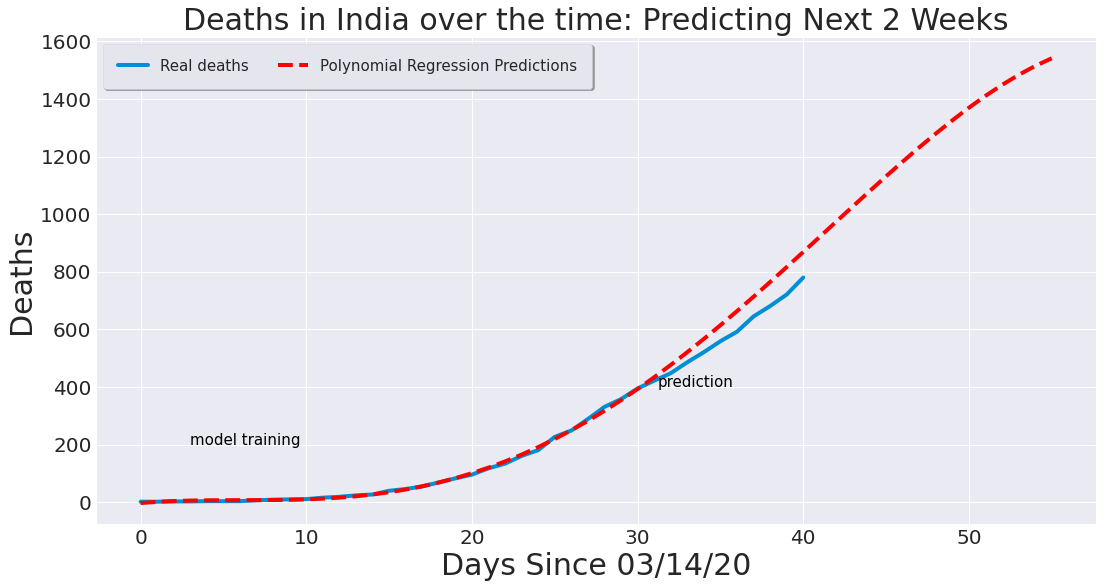

In [103]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates_deaths
         , India_deaths
         , label = "Real deaths")

plt.plot(future_forcast_deaths
         , linear_pred_death
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='red')

plt.title('Deaths in India over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)



plt.text(3, 200
         , "model training"
         , size = 15
         , color = "black")

plt.text(31.2
         , 400
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

In [0]:
#cols = [linear_pred.reshape(-1,1), future_forcast.reshape(-1,1)]

In [0]:
linear_pred_df_20 = linear_pred.tolist()
future_forcast_df_20 = list(future_forcast.astype(int))

In [0]:
linear_pred_df_20 = [item for sublist in linear_pred_df_20 for item in sublist]
future_forcast_df_20 = [item for sublist in future_forcast_df_20 for item in sublist]

In [0]:
predicted_data = pd.DataFrame(linear_pred_df_20)

In [0]:
predicted_data[0] = predicted_data[0].astype(int)

In [0]:
actual = India_cases.tolist()

In [0]:
actual  = [item for sublist in actual for item in sublist]


In [0]:
actual = pd.DataFrame(actual)

In [0]:
predicted_table = predicted_data.merge(actual, how = 'left', left_index=True, right_index=True)

In [113]:
predicted_table

,0_x,0_y
0,105,108.0
1,146,123.0
2,176,134.0
3,200,171.0
4,223,198.0
5,249,256.0
6,283,334.0
7,329,401.0
8,390,503.0
9,471,567.0


In [0]:
predicted_table['Number of Actual Cases'] = predicted_table['0_y']
predicted_table['Number of Predicted Cases'] = predicted_table['0_x']

In [0]:
predicted_table.drop(['0_x','0_y'], inplace=True, axis = 1)

In [0]:
date =pd.date_range(start='03/15/2020', periods=56)

In [0]:
predicted_table.set_index(date, inplace=True)

In [121]:
predicted_table.iloc[33:60,:]

,Number of Actual Cases,Number of Predicted Cases
2020-04-17,14353.0,14688
2020-04-18,15724.0,15921
2020-04-19,17304.0,17204
2020-04-20,18543.0,18537
2020-04-21,20080.0,19917
2020-04-22,21372.0,21342
2020-04-23,23039.0,22812
2020-04-24,24434.0,24323
2020-04-25,NaN,25874
2020-04-26,NaN,27462
